# Background
Using the OATH aurora dataset (http://tid.uio.no/plasma/oath/) which has pre-classified images of either good data [0] (present aurora) or bad data [1] (no aurora,clouds, or moon). This test case is a precursor to building and using this model on USU's Atmospheric Imaging Lab's all-sky imager data. What follows is a breakdown of the code needed in this automated anaylsis procedure.

## Setup
Below is the necessary packages to run the code which can be done on the system independently or with a .yml file (provided on request). The website links are roadmaps that helped complete this work.

In [72]:
#https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook
#https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/
#https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#training

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn import metrics
import glob

In [3]:
path = r'D:\OATH\oath_v1.1'

In [6]:
df = pd.read_csv(path + '\classifications\classifications.csv')

This file 'head' gives a peek at the data within the pandas DataFrame (df). Here we see the first column is the binary classifaction (class2) for good or bad data followed by the 6-term classification for types of aurora and bad conditions (class6). The (picNum) gives the image numeber in the database, (picType) is the classification given to the image, and (rotAng) is the aritrary angle the image is said to rotate in order to remove directional structured bias in the images.  

In [9]:
df.head()

,class2,class6,picNum,picType,rotAng
0,0,2,1,discrete,334
1,0,2,2,discrete,29
2,0,2,3,discrete,355
3,0,0,4,arc,118
4,0,0,5,arc,55


"train_test_split" fuction is designed to randomly choose from the overall data set a test-set and train-set for the model. In this case we went with the 70-30 convention, where 70% goes towards training and 30% towards testing. These sets are then saved for reproducibility of the results (train.csv and test.csv).

In [10]:
train,test = train_test_split(df, test_size=0.30, random_state=0)
#save the data
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

df_train.to_csv(path + r'\classifications' + r'\train.csv', index=False)
df_test.to_csv(path + r'\classifications' + r'\test.csv', index=False)

The '.value_counts' of the training data set is to ensure that there is not a large bias in the training towards good or bad data.

In [91]:
df_train['class2'].value_counts()

0    2306
1    1770
Name: class2, dtype: int64

In [62]:
imgnum=df_train['picNum'].to_numpy()
imgfiles=r'D:\OATH\oath_v1.1\images\cropped_scaled'
rotate=df_train['rotAng'].to_numpy()
y_train=df_train['class2'].to_numpy()

In [67]:
filesq=glob.glob(imgfiles+r'\*****.png')
testFrame=cv2.imread(filesq[0],2)
testFrame=testFrame/np.max(testFrame)
a=testFrame.reshape(-1)
np.size(a)

65536

Even though the images are in the folder 'corpped_scaled' they are only cropped to equal 256x256 pixel arrays but the intesity is not normalized. Below is the last part of data processing where they are rotated in 90 degree increments (based on their rotation angle given to enure reproducibility) and normalized in greyscale. Lastly rather than keep their 2-D array shape they are reduced to a 1-D vector of pixels to increase in processing speed.

In [88]:
X_train = np.zeros((np.size(imgnum),np.size(a)))
for k in range(np.size(imgnum)):
    b=int(imgnum[k])-1
    readFrame=cv2.imread(filesq[b],2)
    if (rotate[k] <= 90):
        readFrame=readFrame
    if (rotate[k] > 90 and rotate[k] < 180):
        readFrame=cv2.rotate(readFrame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if (rotate[k] > 180 and rotate[k] < 270):
        readFrame=cv2.rotate(readFrame, cv2.ROTATE_180)
    else:
        readFrame=cv2.rotate(readFrame, cv2.cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(r'D:\OATH\oath_v1.1\images\cropped_scaled_rotated\train'+str(imgnum[k])+'.png',readFrame)
    X_train[k,:]=readFrame.reshape(-1)/np.max(readFrame)
    
    

## Machine Learning
Now we are ready to perform training of the algorithm. L

In [69]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [89]:
imgnum=df_test['picNum'].to_numpy()
imgfiles=r'D:\OATH\oath_v1.1\images\cropped_scaled'
rotate=df_test['rotAng'].to_numpy()
y_test=df_test['class2'].to_numpy()
filesq=glob.glob(imgfiles+r'\*****.png')
testFrame=cv2.imread(filesq[0],2)
testFrame=testFrame/np.max(testFrame)
a=testFrame.reshape(-1)
np.size(a)
X_test = np.zeros((np.size(imgnum),np.size(a)))
for k in range(np.size(imgnum)):
    b=int(imgnum[k])-1
    readFrame=cv2.imread(filesq[b],2)
    if (rotate[k] <= 90):
        readFrame=readFrame
    if (rotate[k] > 90 and rotate[k] < 180):
        readFrame=cv2.rotate(readFrame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if (rotate[k] > 180 and rotate[k] < 270):
        readFrame=cv2.rotate(readFrame, cv2.ROTATE_180)
    else:
        readFrame=cv2.rotate(readFrame, cv2.cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(r'D:\OATH\oath_v1.1\images\cropped_scaled_rotated\test'+str(imgnum[k])+'.png',readFrame)  
    X_test[k,:]=readFrame.reshape(-1)/np.max(readFrame)

In [71]:
y_pred=clf.predict(X_test)

In [73]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9399


In [74]:
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 1.0000


In [75]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9399


In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[926  44]
 [ 61 717]]

True Positives(TP) =  926

True Negatives(TN) =  717

False Positives(FP) =  44

False Negatives(FN) =  61


<AxesSubplot:>

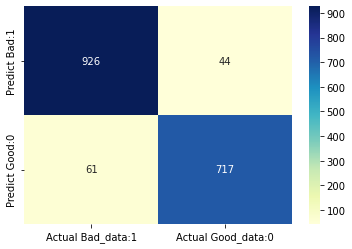

In [90]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Bad_data:1', 'Actual Good_data:0'], 
                                 index=['Predict Bad:1', 'Predict Good:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       970
           1       0.94      0.92      0.93       778

    accuracy                           0.94      1748
   macro avg       0.94      0.94      0.94      1748
weighted avg       0.94      0.94      0.94      1748



In [94]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

ValueError: Found input variables with inconsistent numbers of samples: [1748, 4076]

In [98]:
X_test.shape

(1748, 65536)